# --------------------------  CVA Avec Modèle de Jump  ------------------------

# I- process du taux de change avec saut proportionnel et intensité stochastique

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [40]:
# FX avec intensité constante
def Processus_jump_multi(t,lamda,J):
    sigmaX,r=0.2,0.05
    X0=1.14
    N=10000  # Tragectoire de MC
    
    Int=[0]*N  #Intégrale de l'intensité
    U=np.random.standard_normal(N)  # N trajectoire de MC
    Uniform=np.random.uniform(0,1,N) # N uniforme pour déterminer l'instant de défaut
    Tho=0   # Instant de défaut
    Xt=[]   # Valeur du process
    
    for i in range(N):
        Xb=X0*np.exp((r-0.5*sigmaX**2)*t+sigmaX*np.sqrt(t)*U[i])
        Tho=-np.log(1-Uniform[i])/lamda # car l'instant de défaut est un processus de poisson d'intensité constante lamda
        if Tho>t:  # L'instant de défaut est supérieur à t
            Xt.append(Xb*np.exp(-lamda*J*t))
        else:
            Xt.append(Xb*(1+J)*np.exp(-lamda*J*Tho))
    MonteCarlo_value=sum(Xt)/N
    
    return MonteCarlo_value

In [41]:
t=0
lamda=0.1
J=0.1
Processus_jump_multi(t,lamda,J)

1.1399999999999388

In [57]:
# FX avec intensité constante
def FX_Int_Const(cor,T,J):
    sigmaX,sigmaL=0.2,0.2
    X0,Lamda0=1.14,1
    N=10000  # Tragectoire de MC
    M= 100  # Subdivision de l'intervalle de temps
    
    Xt=0
    Uniforme=np.random.uniform(0,1,N)
    for i in range(N):
        t,Int=0,0
        # Détermination de l'instant de défaut 
        while t<=T:
            t+=T/M
            #Calcul de St et Lambdat qui sont corrélés 
            V,W=np.random.multivariate_normal([0,0],[[1,cor],[cor,1]],1).T # 2 normales corrélées
            Xbt=X0*np.exp((-0.5*sigmaX**2)*t+sigmaX*np.sqrt(t)*W)
            Lamdat=Lamda0*np.exp((-0.5*sigmaL**2)*t+sigmaL*np.sqrt(t)*V)
            Int+=Lamdat*T/M  #Intégrale de l'intensité
            # Détermination de l'instant de défaut
            if Uniforme[i]<=1-np.exp(-Int):
                Tho=t
                X=Xbt*(1+J)*np.exp(-Int*J)
                break
        if t>T: # Le cas où il n'y a pas défaut
            X=Xbt*np.exp(-Int*J)
        Xt+=X/N # CVA est un espérance du payoff à l'instant de défaut
    return Xt

In [58]:
FX_Int_Const(0.5,1,0.1)

array([1.1455738])

In [59]:
# FX avec intensité stochastique conditionnel l'instant de défaut en t
def InLambda(Lamda0,sigmaL,t): # Calcul d'intégrale entre 0 et t
    N=10000 #Itération MC
    M=500 # Subdivision pour intégrale entre 0 et t
    LamdaRN=0
    # Calcul de l'intégrale de l'intensité
    for i in range(1,M):
        Ti=i*t/M
        W=np.random.standard_normal(N)
        Lamda=0
        for j in range(N):
            Lamda+=np.exp(-Ti*sigmaL**2/2+sigmaL*np.sqrt(Ti)*W[j])
        LamdaRN+=Lamda/N
    LamdaRN*=Lamda0*t/N
    
    return LamdaRN
    
def FX(cor,t,J):
    X0,Lamda0=1.14,1
    sigmaX,sigmaL=0.17,0.2
    N=10000 #Itération MC
    LamdaRN=InLambda(Lamda0,sigmaL,t)
    # Faire apparaître la corrélation entre les deux browniens
    V,W=np.random.multivariate_normal([0,0],[[1,cor],[cor,1]],N).T
    x=0
    for i in range(N):
        x+=(sigmaX*np.sqrt(t)*V[i]-J*Lamda0*np.exp(-t*sigmaL**2/2+sigmaL*np.sqrt(t)*W[i]))/N
    x=-t*sigmaX**2/2+x-J*LamdaRN
    #FX avec jump
    Xt=(1+J)*X0*np.exp(x)
    return Xt  
        

In [60]:
Tho=0.5 # Espérance de l'instant de défaut
FX(0.5,0.5,0.1)

1.1253610442372677

# II- Implementation de la CVA avec MC

In [61]:
def CVA_WWR(cor,T,J):
    M=100
    N=100
    sigmaL,Lamda0=0.2,1
    CVA=0
    for i in range(1,M+1):
        Ti=i*T/M
        W=np.random.standard_normal(N)
        Lamda=0
        for j in range(N):
            Lamda+=Lamda0*np.exp(-Ti*sigmaL**2/2+sigmaL*np.sqrt(Ti)*W[j])/N
        CVA+= np.exp(-InLambda(Lamda0,sigmaL,Ti))*FX(cor,Ti,J)*Lamda
    return CVA
            

In [ ]:
CVA_WWR(0.5,5,0.1)

In [101]:
CVA_WWR(0.5,5,0.1)

1.0923322835387264

# III- Approximation du ration CVA (WWR/IND)

In [102]:
def Ratio(cor,T,J):
    Lamda0,sigmaL=0.01,0.2
    sigmaX=0.17
    r=(1-np.exp(-(1+J)*Lamda0*T))/(1-np.exp(-Lamda0*T))+0.5*(1+J)*Lamda0*cor*sigmaL*sigmaX*np.exp(-(1+J)*Lamda0*T)*T**2
    return r

In [103]:
Ratio(0.5,5,0.1)

1.0981623998268923

In [104]:
def Ratio_CVA(cor,T,J):
    return CVA_WWR(cor,T,J)/CVA_WWR(0,T,J)

In [105]:
Ratio(0.5,5,0.1)/Ratio_CVA(0.5,5,0.1)

1.0035292242955032

# IV- Tests

# a- processus pur saut

In [109]:
J=[i*0.2/100 for i in range(101)]
sigmaL=[i*0.5/100 for i in range(101)]
X=[Ratio_CVA(5,j,0.0) for j in J]
Y=[Ratio_CVA(5,0.0,sig) for sig in sigmaL]

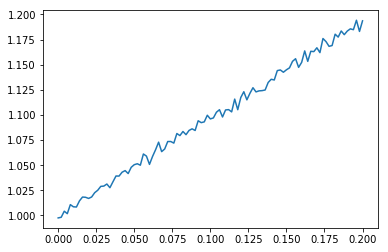

In [110]:
plt.plot(J,X)
plt.show()

# b- Processus pur intensité stochastique

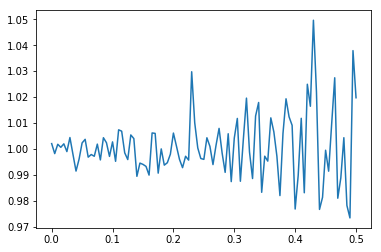

In [111]:
plt.plot(sigmaL,Y)
plt.show()

# c- Approximation du ratio de la CVA

In [112]:
W=[Ratio(5,j,0.0) for j in J]
V=[Ratio(5,0.0,sig) for sig in sigmaL]

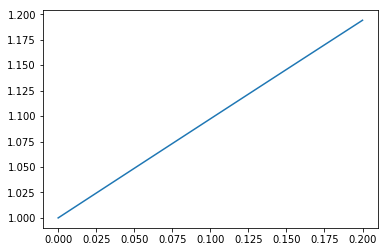

In [113]:
plt.plot(J,W)
plt.show()

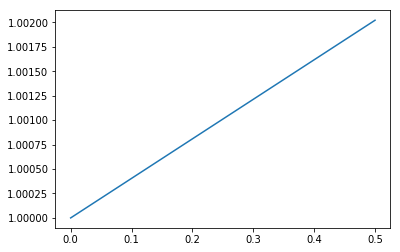

In [115]:
plt.plot(sigmaL,V)
plt.show()

# CVA avec intensité déterministe

In [118]:
def FXD(t,J,Lamda):
    X0=1.14
    sigmaX=0.17
    N=100 #Itération MC
    Xt_B=0
    # Faire apparaître la corrélation entre les deux browniens
    W=np.random.standard_normal(N)
    for j in range(N):
        Xt_B+=np.exp(-t*sigmaX**2/2+sigmaX*np.sqrt(t)*W[j])/N
    Xt=(1+J)*X0*Xt_B*np.exp(-Lamda*J*t)
    return Xt  

In [119]:
FXD(5,0.1,0.01)

1.2491372873708897

In [ ]:
def CVA_WWR_D(T,J,Lamda):
    M=100
    N=50
    CVA=0
    for i in range(1,M+1):
        Ti=i*T/M
        W=np.random.standard_normal(N)
        Lamda=0
        for j in range(N):
            Lamda+=*np.exp(-Ti*sigmaL**2/2+sigmaL*np.sqrt(Ti)*W[j])/N
        CVA+= np.exp(-InLambda(Lamda0,sigmaL,Ti))*FXD(Ti,J,Lamda)*Lamda
    return CVA

In [ ]:
def CVA_ind():
    T,sigmaS,sigmaL,K,r=1.0,0.2,0.2,100,0.05
    S0,Lamda0=100,1
    N=1000  # Tragectoire de MC
    M= 100  # Subdivision de l'intervalle de temps
    
    Lamda=[0]*N
    Int=[0]*N  #Intégrale de l'intensité
    U=np.random.standard_normal(N)  # N trajectoire de MC
    for i in range(N):
        x=Lamda0*np.exp((-0.5*sigmaL**2)*T/M+sigmaL*np.sqrt(T/M)*U[i])
        Lamda[0]+=x/N
        Int[0]+=x*T/M
        for j in range(1,M):
            x=Lamda0*np.exp((-0.5*sigmaL**2)*(j+1)*T/M+sigmaL*np.sqrt((j+1)*T/M)*U[i])
            Lamda[j]+=x/N
            Int[j]+=Int[j-1]+x*T/M
    CVA=0
    for j in range(M):
        #Fonction densité de l'instant de défaut à tj
        densite=Lamda[j]*np.exp(-Int[j])
        #CVA en Riemann
        CVA+=BSM_payoff([S0,K,T,r,sigmaS],(j+1)*T/M)*densite*T/M
    return CVA

In [ ]:
Int=Lamda0*np.exp((-0.5*sigmaL**2)*T/M+sigmaL*np.sqrt(T/M)*U[i])*T/M
        j=2
        while j<=M:
            if Uniform[i]>=1-np.exp(-Int):
                Tho=j*t/M
            x=Lamda0*np.exp((-0.5*sigmaL**2)*j*t/M+sigmaL*np.sqrt(j*t/M)*U[i])
            Int+=x*T/M
            j+=1